In [1]:
%matplotlib inline
#%matplotlib notebook

In [2]:
import cytoflow as flow
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
matplotlib.rc('figure', dpi = 160)

# Import samples and specify experimental condtions

In [3]:
inputs = [
    #["Experiment_Tube_001_001.fcs",1e-4,0],
    ["Experiment_Tube_002_002.fcs",1e-6, 0],
    ["Experiment_Tube_003_003.fcs",1e-8, 0],
    ["Experiment_Tube_004_004.fcs",1e-10, 0],
    ["Experiment_Tube_005_005.fcs",1e-12, 0],
    ["Experiment_Tube_006_006.fcs",1e-4, 2e-4],
    ["Experiment_Tube_007_007.fcs",1e-6,2e-4],
    ["Experiment_Tube_008_008.fcs",1e-8,2e-4],
    ["Experiment_Tube_009_009.fcs",1e-10, 2e-4],
    ["Experiment_Tube_010_010.fcs",1e-12, 2e-4],
    ["Experiment_Tube_011_011.fcs",1e-4, 1e-3],
    ["Experiment_Tube_012_012.fcs",1e-6, 1e-3],
    ["Experiment_Tube_013_013.fcs",1e-8, 1e-3],
    ["Experiment_Tube_014_014.fcs",1e-10,1e-3],
    ["Experiment_Tube_015_015.fcs",1e-12, 1e-3],
 
]

       
tubes = []
for filename, ahl, iptg in inputs:
    tubes.append(flow.Tube(file = 'data/' + filename, conditions = {'AHL' : ahl, 'IPTG' : iptg}))
    
ex = flow.ImportOp(conditions = {'AHL' : 'float', 'IPTG' : 'float'},
                   tubes = tubes).apply()
       


In [4]:
flow.set_default_scale("log")

## Effect of fixation time on mNG intensity

# Plot FITC-A histograms for all IPTG and AHL induction conditions

C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10


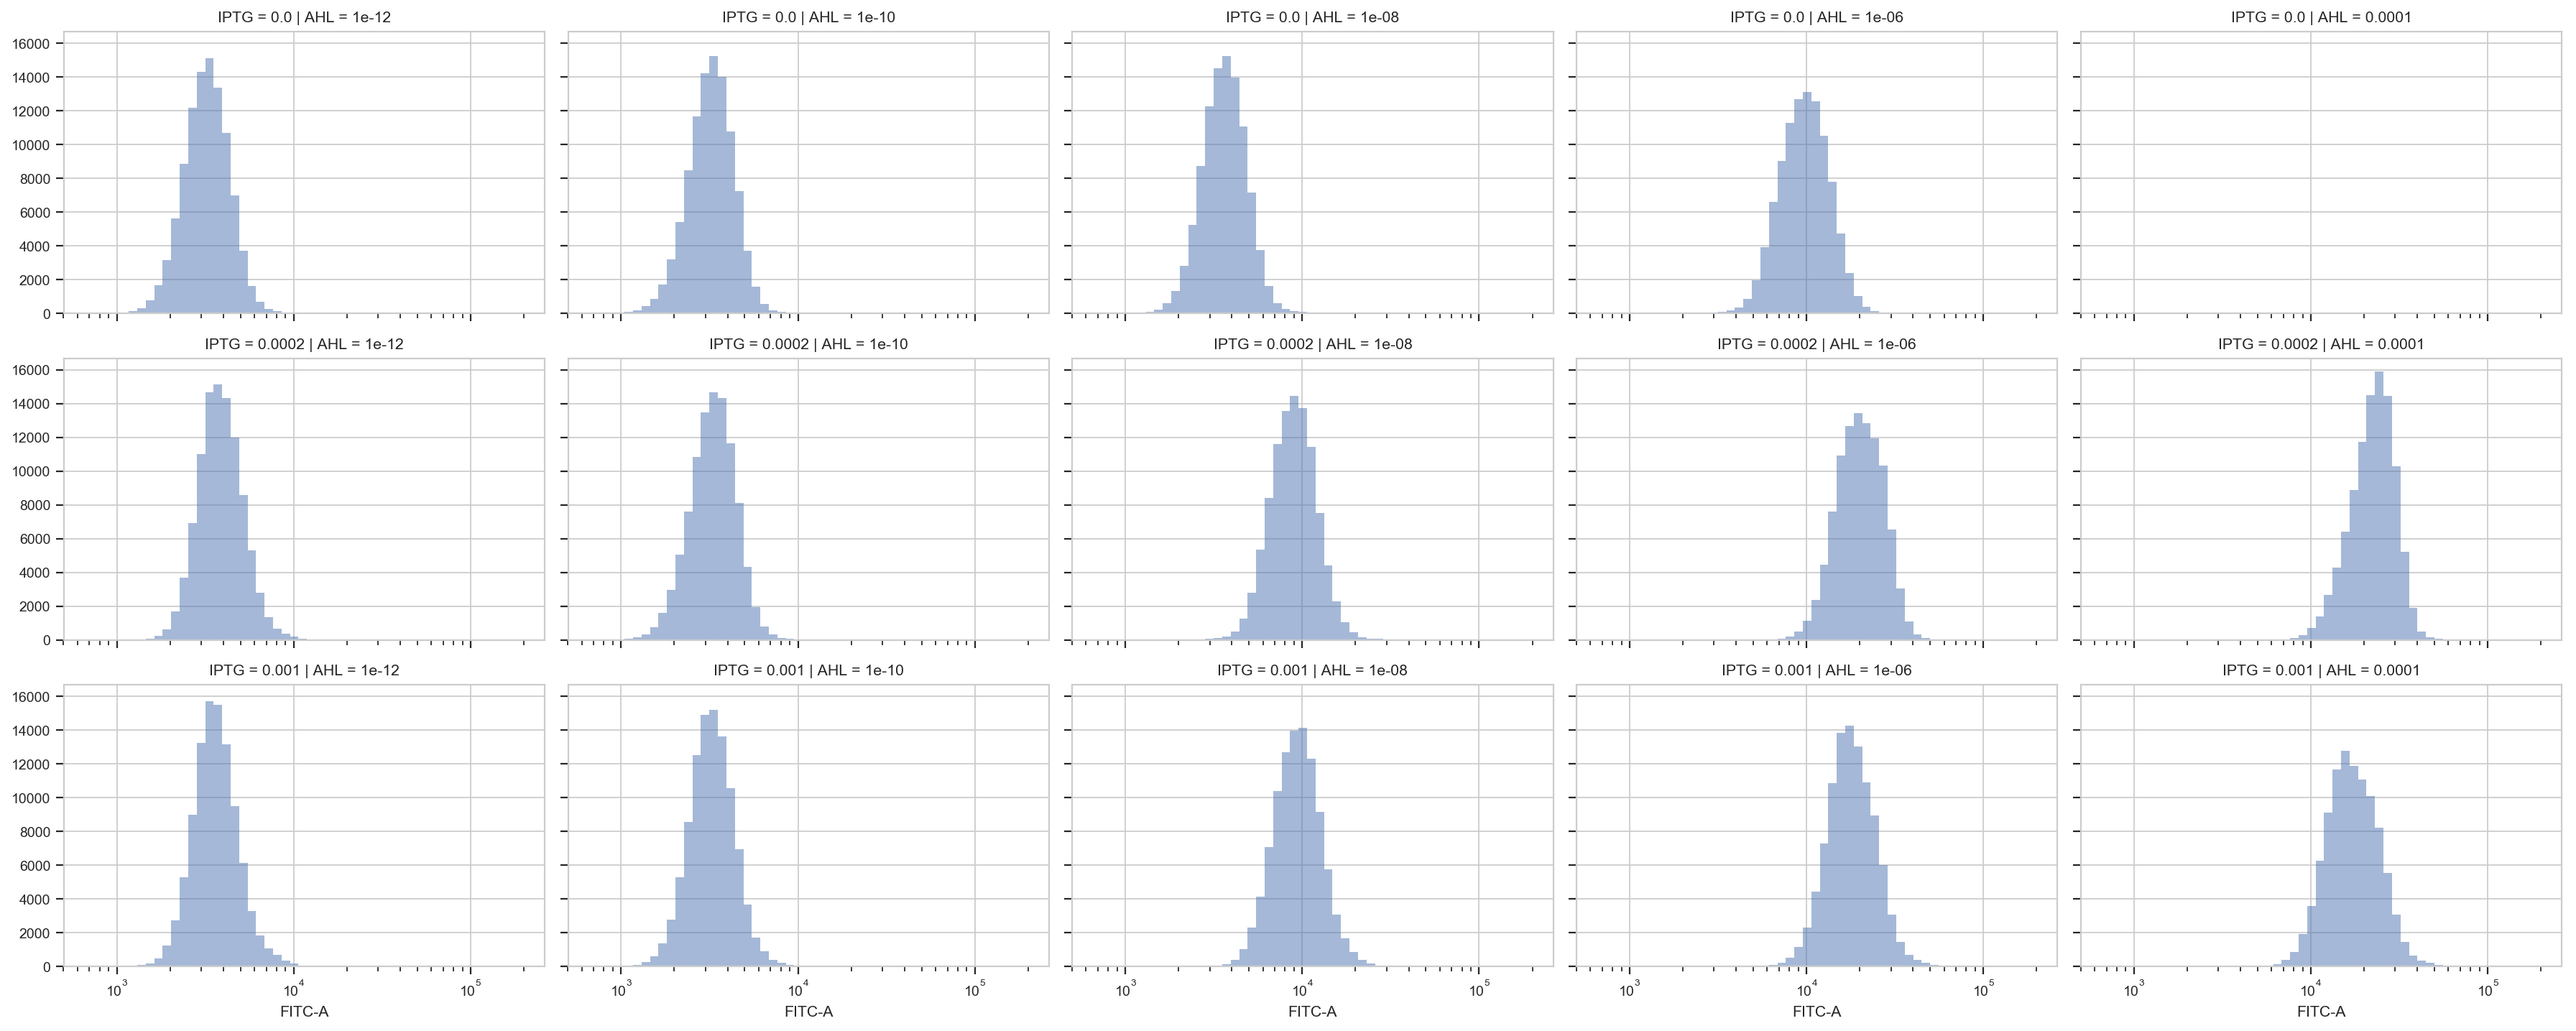

In [5]:

flow.HistogramView(channel = "FITC-A",
                   xfacet = "AHL",
                  yfacet = 'IPTG').plot(ex)

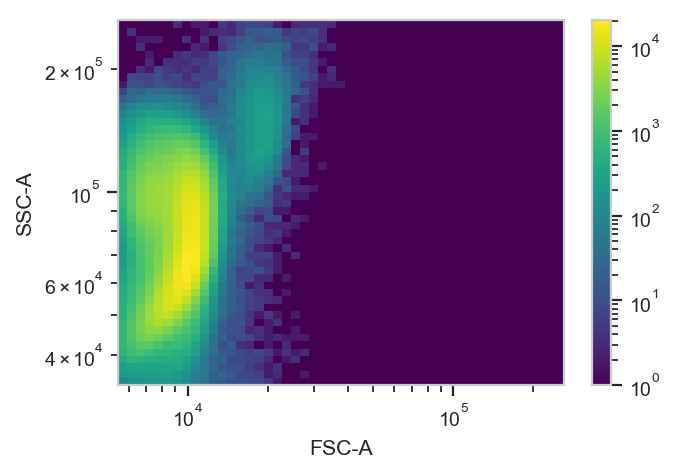

In [6]:
flow.DensityView(xchannel = "FSC-A", 
                 ychannel = "SSC-A",
                 xscale = 'log',
                 yscale = 'log').plot(ex, min_quantile = 0.005)

# Singlet gating to remove doublets

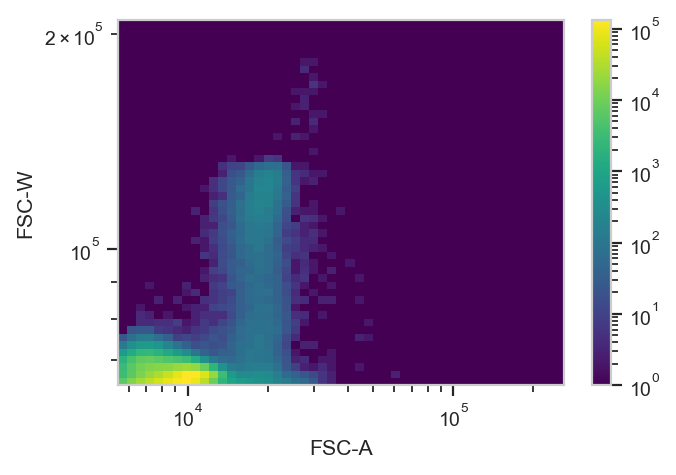

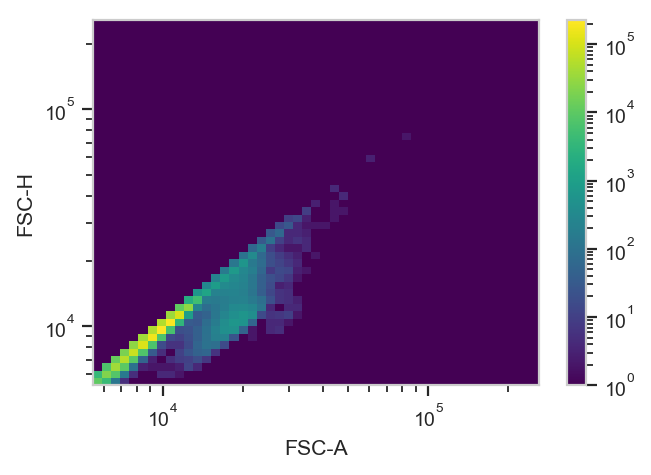

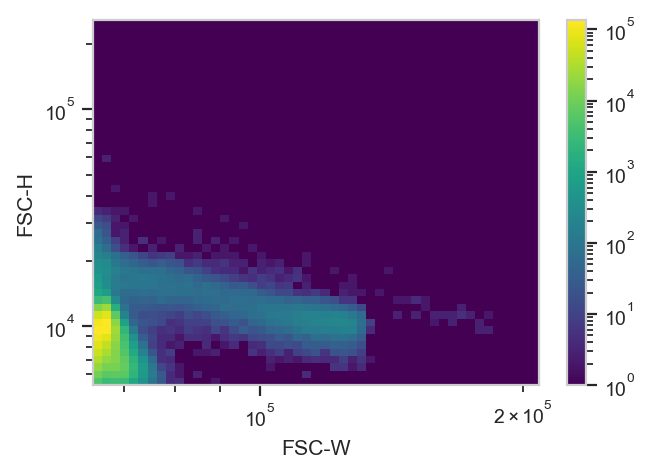

In [7]:

#channels = ['FSC-A','FSC-W','FSC-H','SSC-A','SSC-W','SSC-H']
#perm = combinations(channels,2)
FSC = [('FSC-A','FSC-W'),('FSC-A','FSC-H'),('FSC-W','FSC-H')]

#f, axes = plt.subplots(ncols=4,nrows=4)
#axs = axes.ravel()
for i,(x,y) in enumerate(FSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'log',
                yscale = 'log').plot(ex, min_quantile = 0.005)


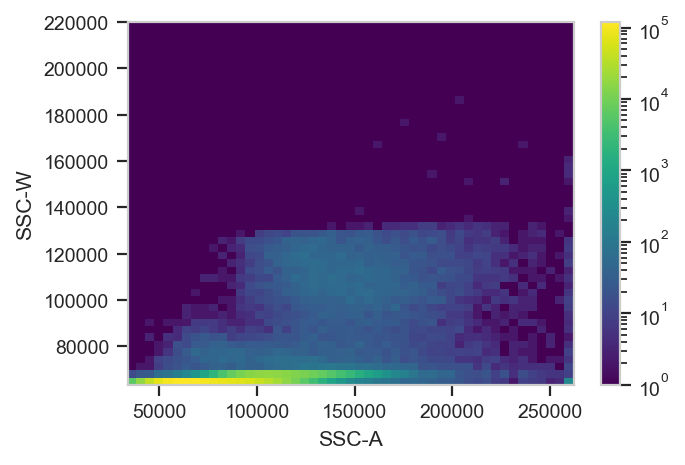

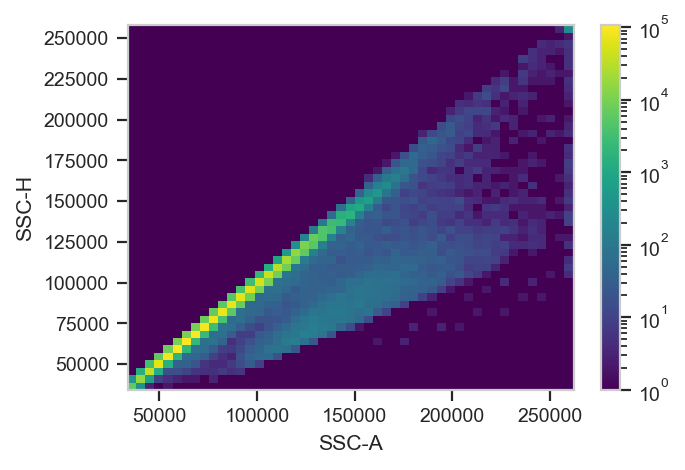

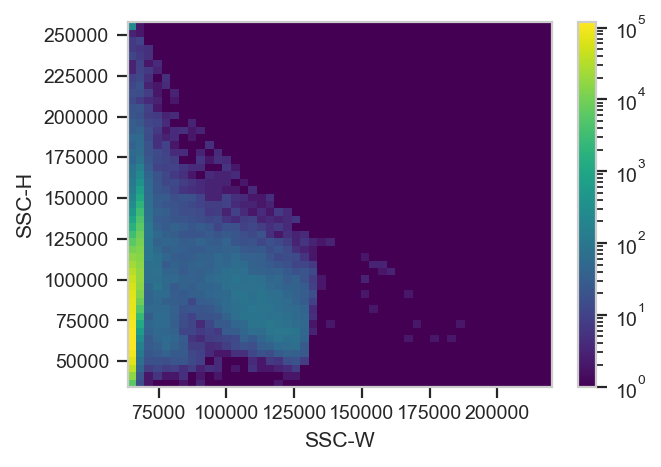

In [8]:
SSC = [('SSC-A','SSC-W'),('SSC-A','SSC-H'),('SSC-W','SSC-H')]
for i,(x,y) in enumerate(SSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'linear',
                yscale = 'linear').plot(ex, min_quantile = 0.005)

## Create and store singlet gate

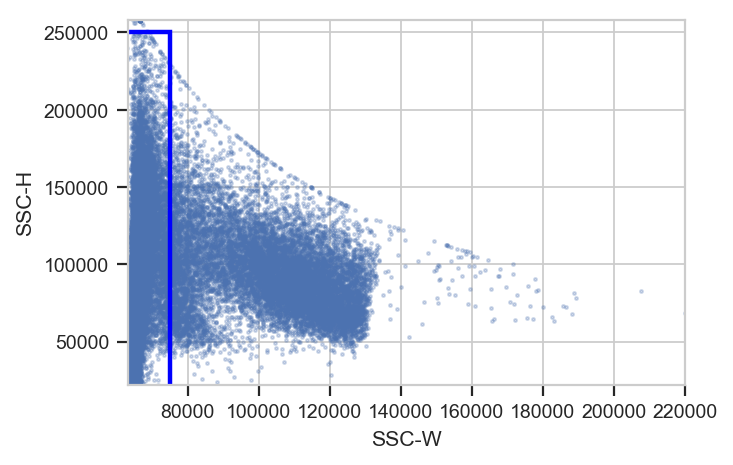

In [9]:
r = flow.Range2DOp(name = "Range2D",
                   xchannel = "SSC-W",
                   xlow = 55000,
                   xhigh = 75000,
                   ychannel = "SSC-H",
                   ylow = 5000,
                   yhigh = 250000)
                   
rv = r.default_view(xscale ='linear',yscale='linear')

rv.plot(ex)
ex2 = r.apply(ex)

## Use a gaussian mixture model to further gate the population

C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


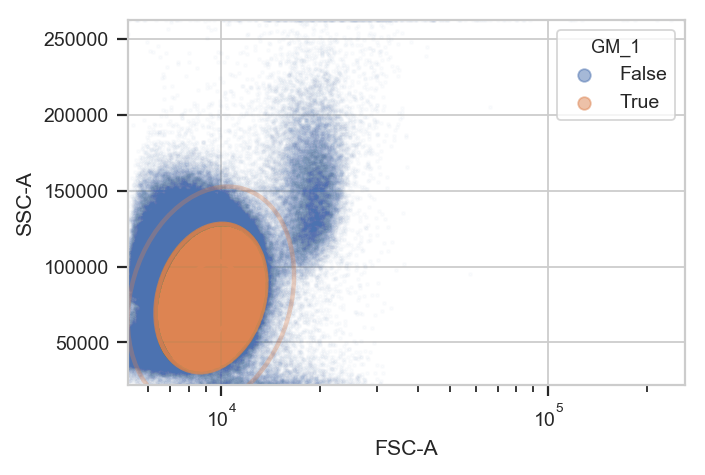

In [10]:
gm = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'linear'},
                            num_components = 1,
                            sigma = 2)
gm.estimate(ex2)
ex_gm = gm.apply(ex2)
gm.default_view().plot(ex_gm, alpha = 0.02)

C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM3_1'


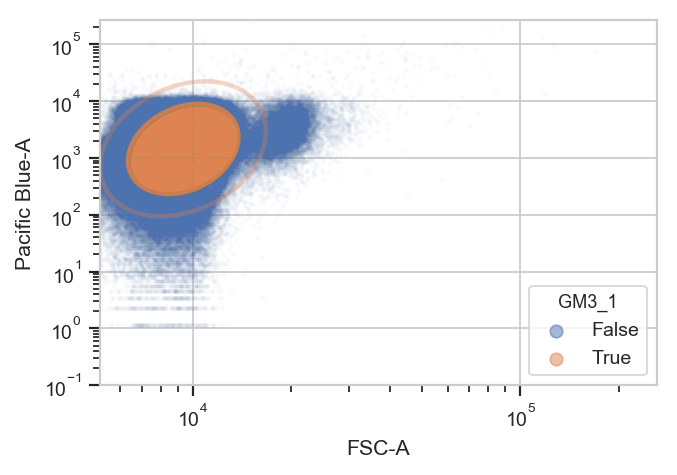

In [11]:
gm3 = flow.GaussianMixtureOp(name = "GM3",
                            channels = ['FSC-A', 'Pacific Blue-A'],
                            scale = {'FSC-A' : 'log',
                                     'Pacific Blue-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm3.estimate(ex_gm)
ex_gm2 = gm3.apply(ex_gm)
gm3.default_view().plot(ex_gm2, alpha = 0.02)

In [12]:
df =ex_gm2.data

# filter out events that don't fall within the gates

In [13]:

df = df[(df.GM_1==True) & (df.GM3_1==True) & (df.Range2D==True) & (df['FITC-A'] >0)]
df

,AHL,FITC-A,FITC-H,FITC-W,FSC-A,FSC-H,FSC-W,IPTG,Pacific Blue-A,Pacific Blue-H,Pacific Blue-W,PerCP-Cy5-5-A,PerCP-Cy5-5-H,SSC-A,SSC-H,SSC-W,Time,Range2D,GM_1,GM3_1
0,1.000000e-06,7241.040039,7237.0,65572.578125,10177.219727,10081.0,66161.515625,0.000,2600.129883,2187.0,77915.921875,11338.599609,11519.0,75534.296875,75185.0,65840.468750,61.200001,True,True,True
2,1.000000e-06,6172.149902,6065.0,66693.820312,9148.620117,9045.0,66286.781250,0.000,1330.010010,1111.0,78455.031250,9759.740234,9523.0,54403.917969,54613.0,65285.101562,61.700001,True,True,True
3,1.000000e-06,12896.099609,13220.0,63930.320312,9133.820312,9024.0,66333.562500,0.000,666.700012,650.0,67219.781250,15868.700195,15022.0,76316.609375,76256.0,65588.093750,61.900002,True,True,True
5,1.000000e-06,11553.089844,11189.0,67668.546875,10717.419922,10609.0,66205.757812,0.000,840.719971,923.0,59693.851562,11619.839844,11483.0,84080.968750,83413.0,66060.812500,61.900002,True,True,True
6,1.000000e-06,11425.819336,11356.0,65938.921875,11379.719727,11240.0,66350.656250,0.000,2882.629883,3082.0,61296.574219,12767.939453,12874.0,93101.117188,91724.0,66519.937500,62.000000,True,True,True
8,1.000000e-06,11529.950195,11277.0,67006.023438,7646.419922,7369.0,68003.218750,0.000,1974.109985,2379.0,54382.210938,13220.059570,13055.0,104971.046875,102505.0,67112.648438,62.700001,True,True,True
10,1.000000e-06,10162.910156,9792.0,68018.437500,10869.860352,10564.0,67433.476562,0.000,4209.250000,3884.0,71024.046875,17812.458984,16904.0,113172.398438,111076.0,66772.898438,63.200001,True,True,True
11,1.000000e-06,9304.950195,8824.0,69108.023438,10865.419922,10684.0,66648.835938,0.000,5234.160156,5463.0,62790.761719,13682.859375,14327.0,90396.406250,89448.0,66230.867188,63.299999,True,True,True
12,1.000000e-06,11276.299805,10884.0,67898.156250,9116.060547,8864.0,67399.609375,0.000,872.359985,1450.0,39428.265625,13320.629883,13022.0,99882.921875,98432.0,66502.023438,64.400002,True,True,True
13,1.000000e-06,15248.370117,14296.0,69901.882812,7651.600098,7116.0,70468.710938,0.000,1397.809937,1292.0,70903.148438,23753.208984,23048.0,113386.890625,109676.0,67753.414062,64.500000,True,True,True


In [14]:
import scipy.stats as stats
import scipy as sp
from scipy.stats.mstats import gmean
import numpy as np

def geom_sd(a):
    a = np.array(a)
    u = gmean(a)
    a[a <= 0] = np.abs(a[a <= 0]) + 2 * u
    
    return np.exp(np.std(np.log(a)))
def geom_sem(a):
    a = np.array(a)
    u = geom_mean(a)
    a[a <= 0] = np.abs(a[a <= 0]) + 2 * u
def geom_std(values):
    """
    Calculates the geometric standard deviation for the passed values.
    Source: https://en.wikipedia.org/wiki/Geometric_standard_deviation
    """

   # gmean = stats.gmean(values)
    return sp.exp(sp.sqrt(sp.sum([sp.log(x / gmean(values)) ** 2 for x in values]) / len(values))) 


In [15]:
data = df[['FITC-A','AHL','IPTG']]
data.to_pickle('./LuxSE.pkl')

# Plot mean FITC-A

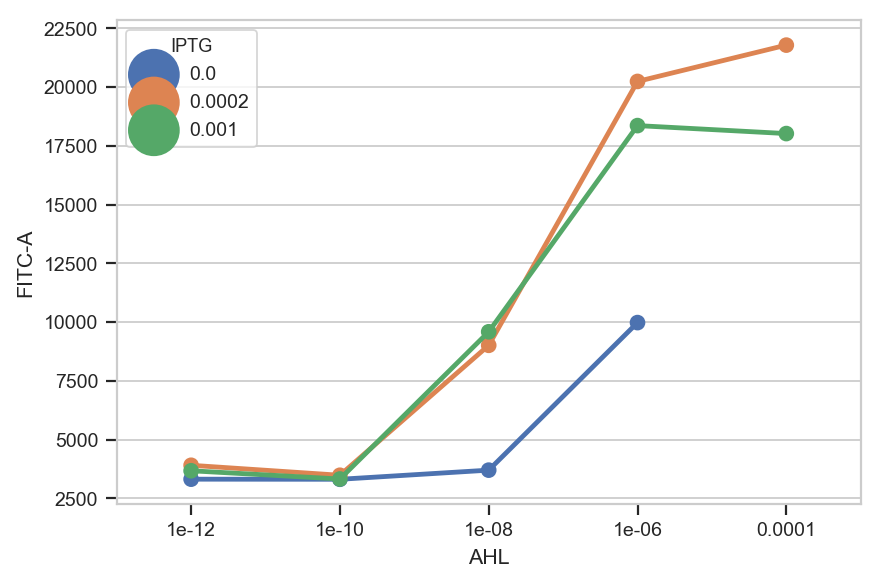

In [16]:
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',data=df)

In [17]:
gb = df.groupby(['AHL','IPTG'])
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
geostd = df.groupby(['AHL','IPTG'])['FITC-A'].apply(geom_sd).reset_index()

std = df.groupby(['AHL','IPTG'])['FITC-A'].std().reset_index()


# Plot Geometric mean FITC-A

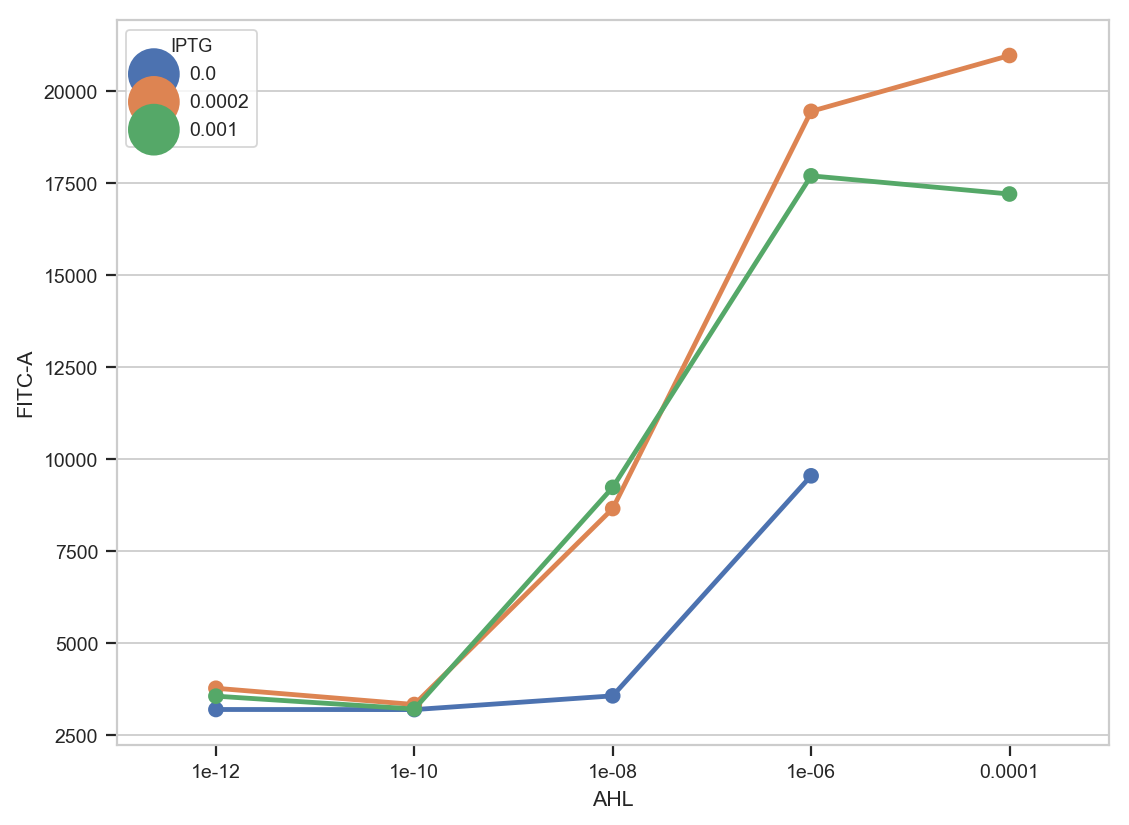

In [18]:
f, ax = plt.subplots(figsize=(8,6))
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',estimator=gmean,ci=0.01,data=df)
f.savefig('Lux.png',dpi=600)

In [19]:
mean

,AHL,IPTG,FITC-A
0,1.000000e-12,0.0000,3195.695276
1,1.000000e-12,0.0002,3772.816271
2,1.000000e-12,0.0010,3558.123646
3,1.000000e-10,0.0000,3193.103654
4,1.000000e-10,0.0002,3330.954809
5,1.000000e-10,0.0010,3208.647370
6,1.000000e-08,0.0000,3566.537591
7,1.000000e-08,0.0002,8655.266508
8,1.000000e-08,0.0010,9231.474032
9,1.000000e-06,0.0000,9545.145612


# Calculate standard deviation percentages

In [20]:
std['FITC-A']/mean['FITC-A']*100

0     28.760033
1     28.023532
2     26.042944
3     27.753385
4     38.264279
5     27.669037
6     28.611469
7     29.488142
8     28.463635
9     31.005441
10    28.779821
11    28.112713
12    26.810922
13    31.222160
Name: FITC-A, dtype: float64

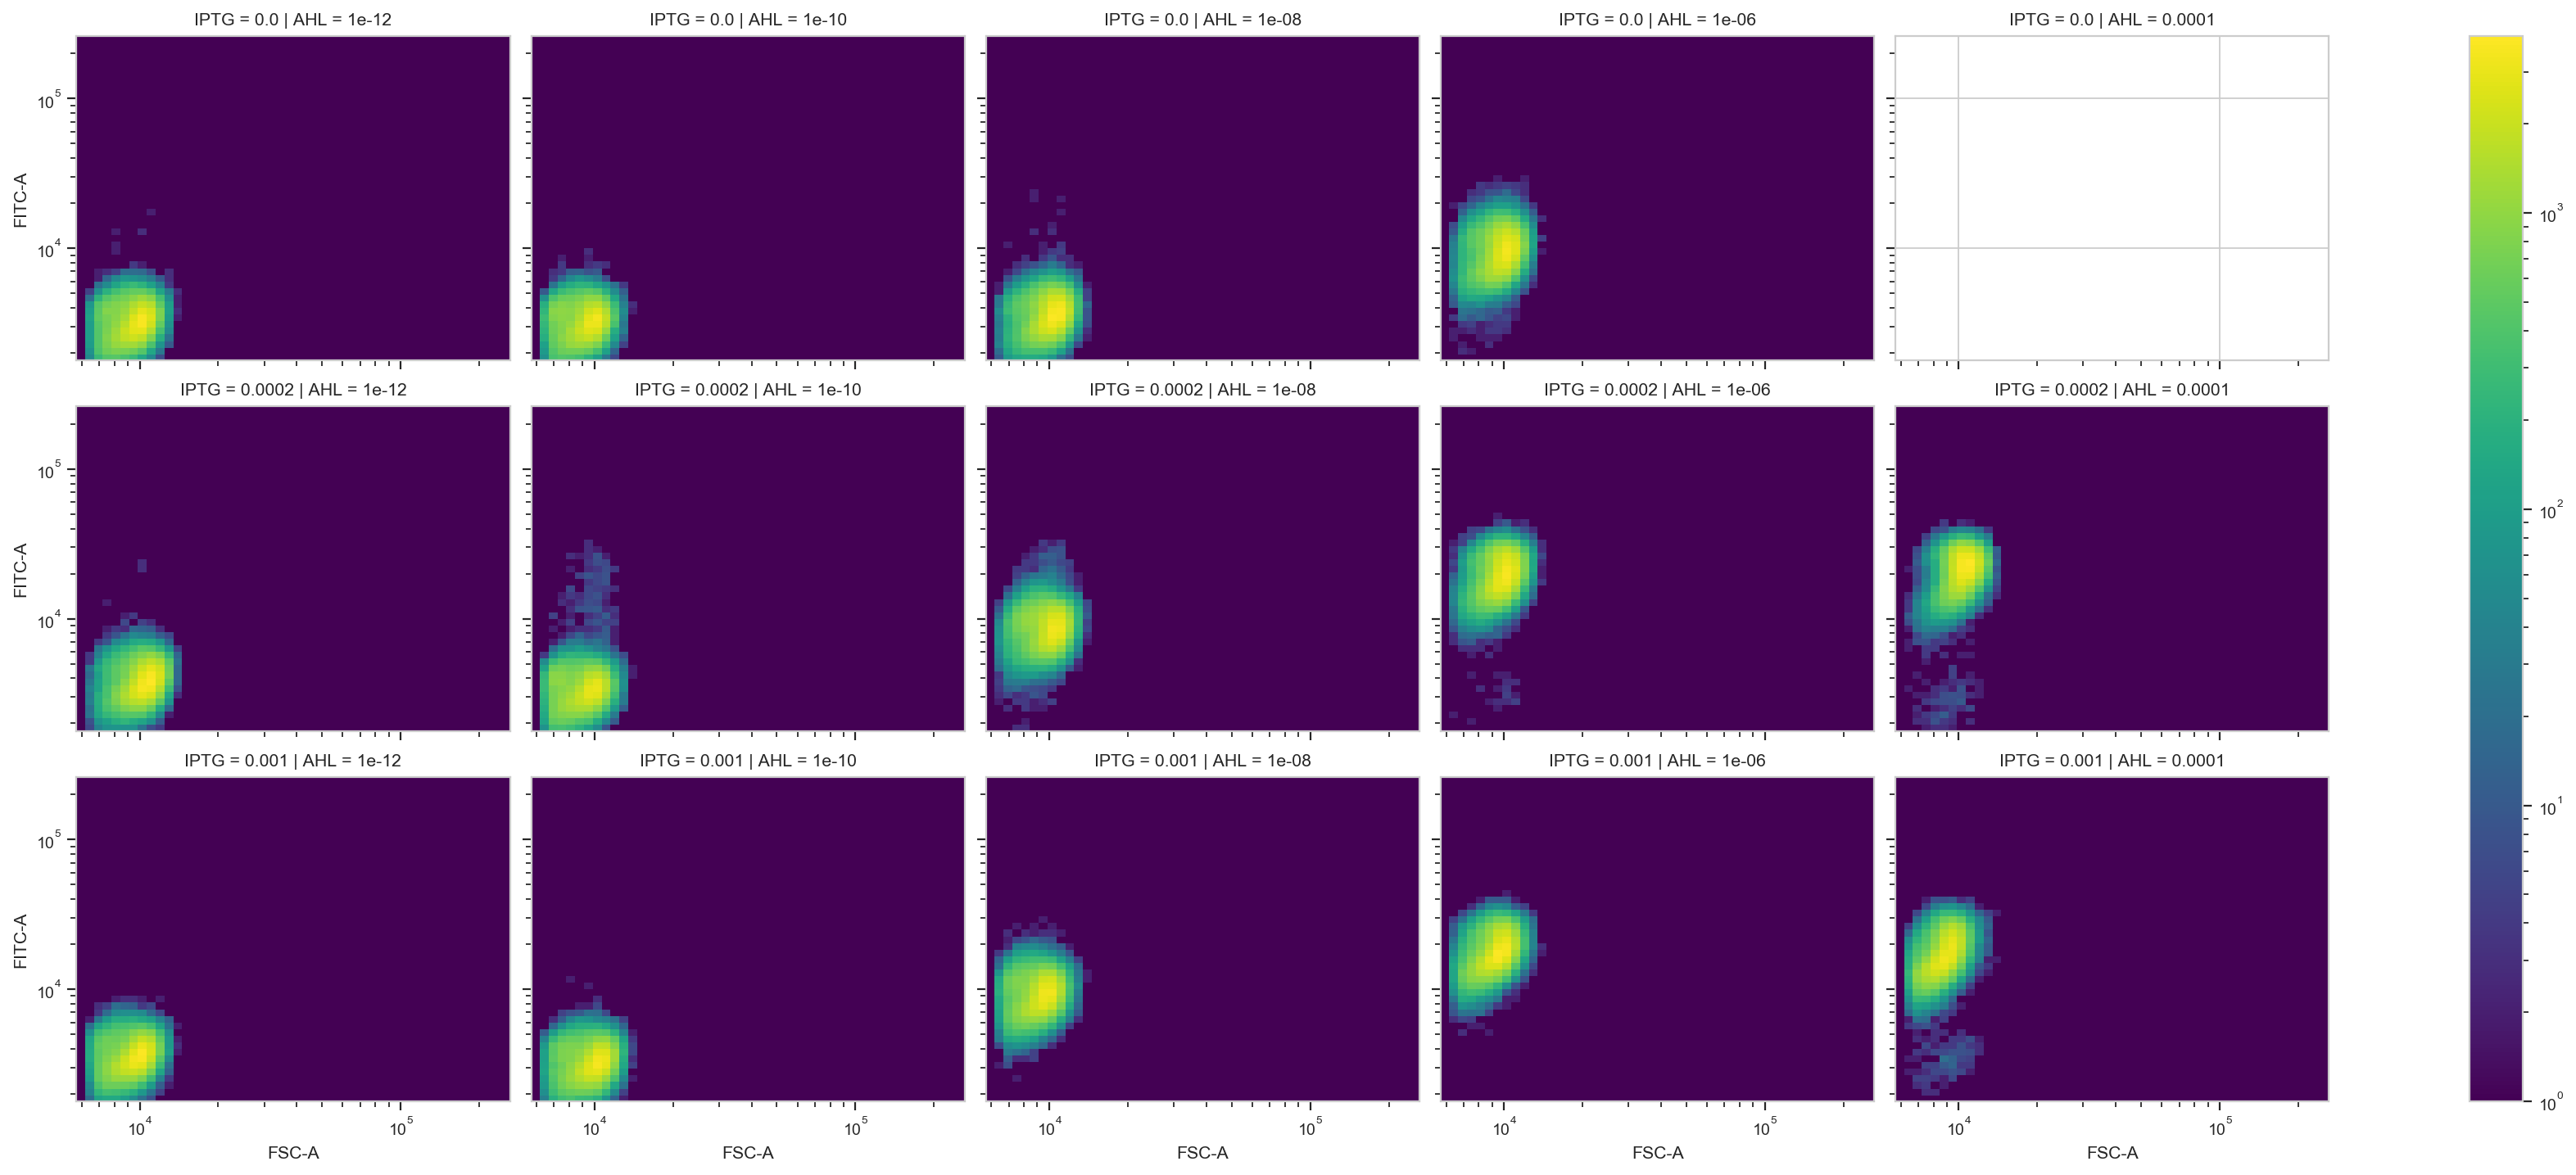

In [21]:

flow.DensityView(xchannel = 'FSC-A', 
                ychannel = 'FITC-A',
                   xfacet = "AHL",
                yfacet='IPTG',
                 subset = 'GM_1 == True').plot(ex_gm2, min_quantile = 0.01)

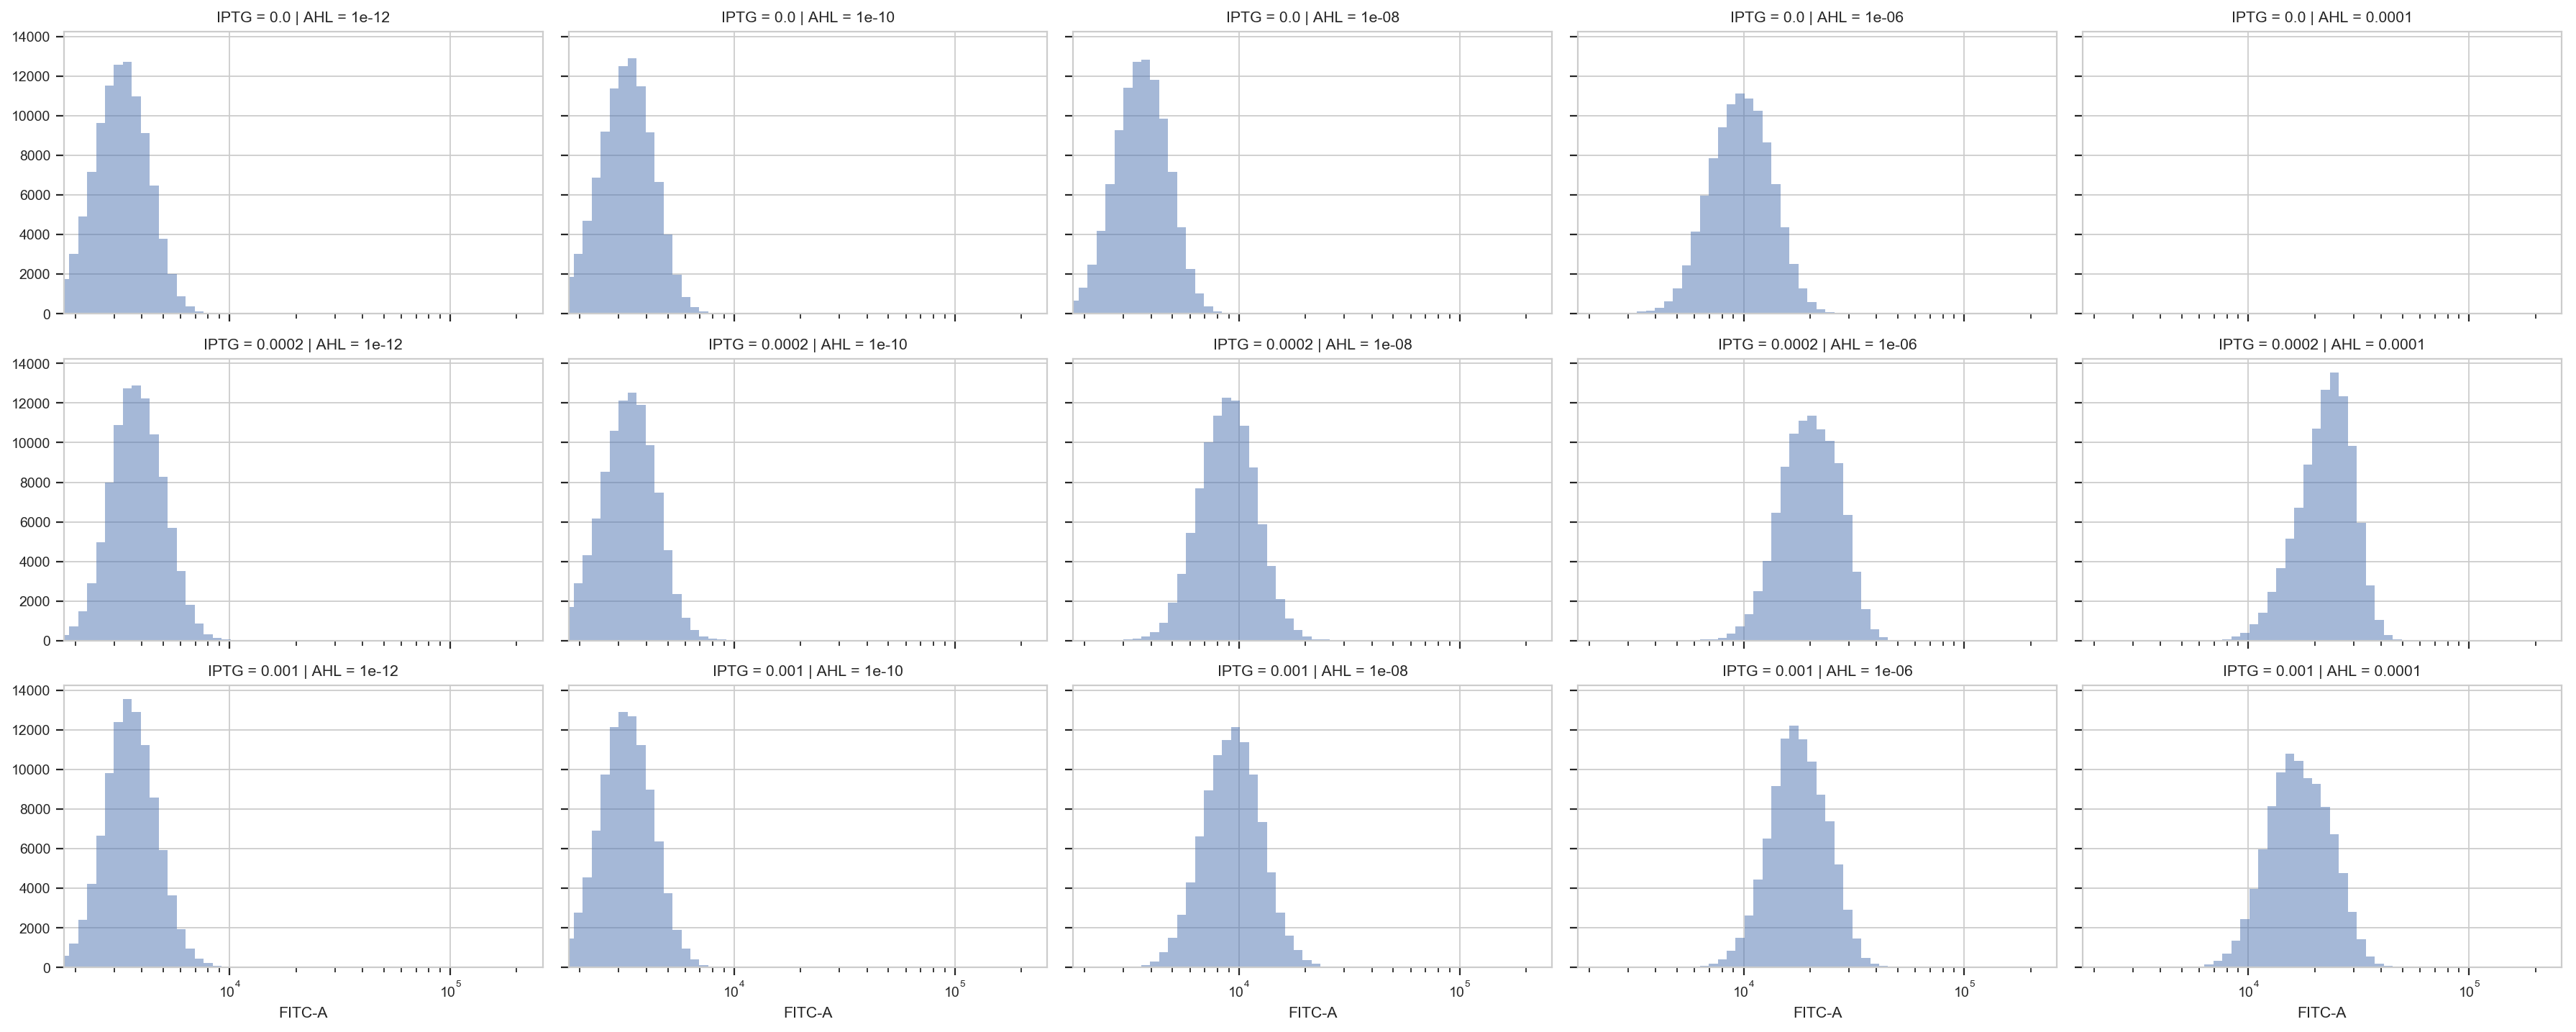

In [22]:
flow.HistogramView(channel = 'FITC-A',
                   xfacet = "AHL",
                yfacet='IPTG',
                 subset = 'Range2D == True').plot(ex_gm2, min_quantile = 0.01)

# Plot heatmaps showing absolute and relative induction

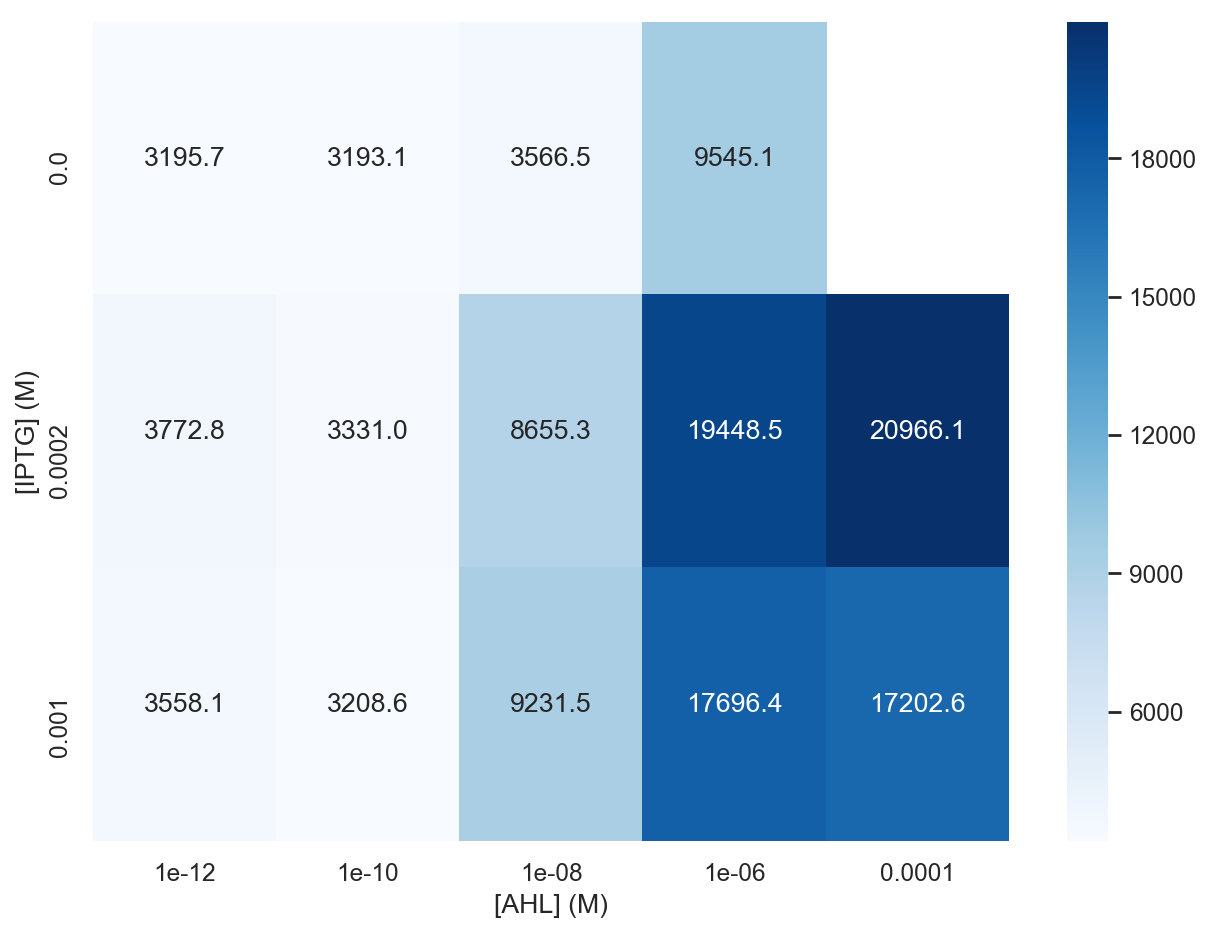

In [23]:
#LasMeans = Las.groupby(['C_ahl','C_iptg']).mean().reset_index()
sns.set(style="white")
#sns.set_style('Talk')
#LasTable = pd.pivot_table(LasMeans,values='FITC-A',index='C_iptg',columns='C_ahl')
f, ax = plt.subplots(figsize=(8,6))
#g = sns.heatmap(LasTable,vmin=0,vmax=100,xticklabels=[0,1e-10,1e-9,1e-7],yticklabels=[0,1e-3,1e-4,1e-5],ax=ax,square=True,cmap='Reds')



#f.savefig('LasHeatmap.png',dpi=600)
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
#mean['FITC-A']=mean['FITC-A']/mean['FITC-A'].max()*100

piv = mean.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
#cbar.set_ticks([0, 25, 50, 75,100])
#cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

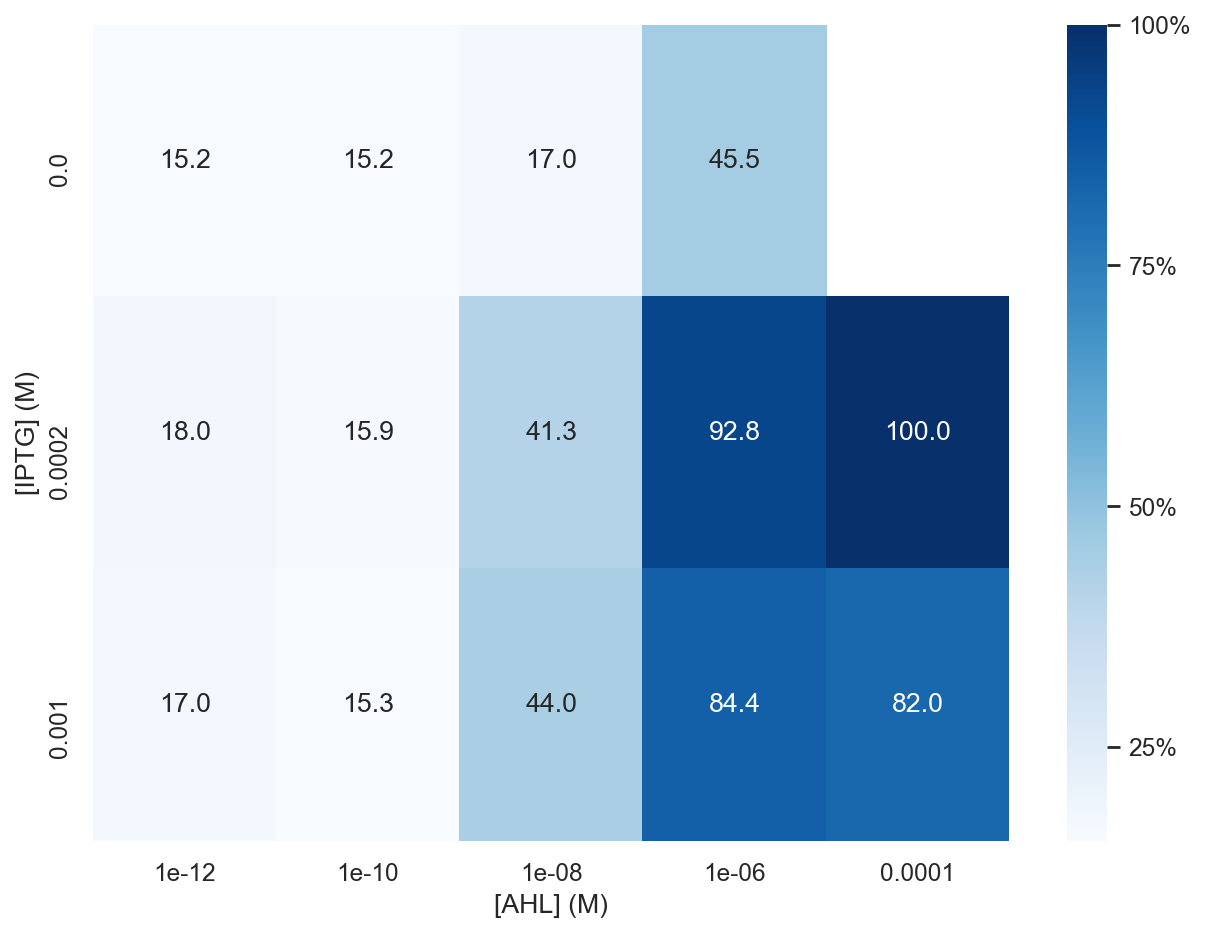

In [24]:
f, ax = plt.subplots(figsize=(8,6))
# normalized
mean['FITC-A']=mean['FITC-A']/mean['FITC-A'].max()*100

piv = mean.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75,100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

# Calculate the on/off ratio and plot

In [25]:

R =[]
for i in mean.IPTG.unique():
    tmp = mean[mean.IPTG ==i]['FITC-A'].max()/mean[mean.IPTG ==i]['FITC-A'].min()
    R.append([i,tmp])



In [26]:

R = pd.DataFrame(R,columns=['IPTG','Induction Ratio'])
R

,IPTG,Induction Ratio
0,0.0000,2.989300
1,0.0002,6.294320
2,0.0010,5.515206


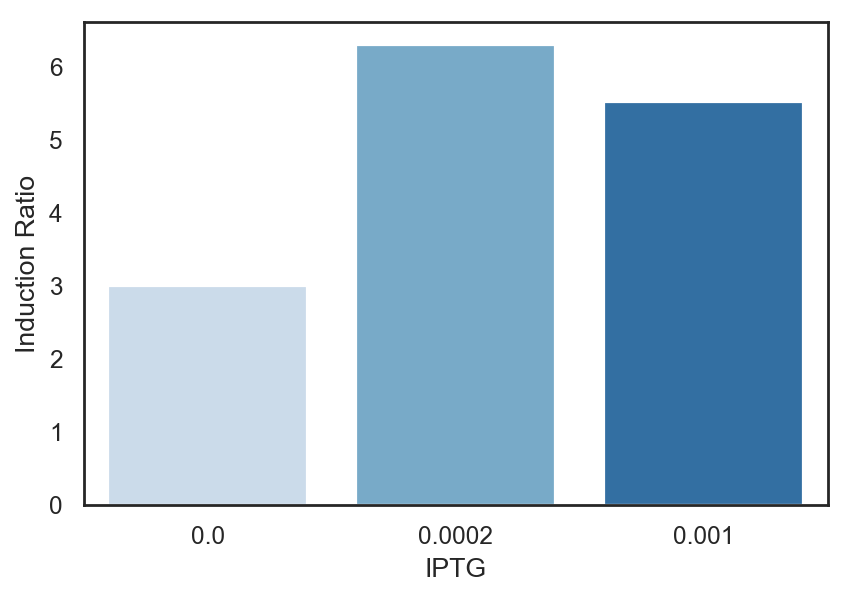

In [27]:
f, ax  = plt.subplots()
sns.barplot(x='IPTG',y='Induction Ratio',data=R,palette='Blues')

# Fit data to logistic function

In [28]:
import scipy.optimize as opt
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
data = mean.copy()
data.AHL[data.AHL == 0]=1e-14


In [29]:
data

,AHL,IPTG,FITC-A
0,1.000000e-12,0.0000,3195.695276
1,1.000000e-12,0.0002,3772.816271
2,1.000000e-12,0.0010,3558.123646
3,1.000000e-10,0.0000,3193.103654
4,1.000000e-10,0.0002,3330.954809
5,1.000000e-10,0.0010,3208.647370
6,1.000000e-08,0.0000,3566.537591
7,1.000000e-08,0.0002,8655.266508
8,1.000000e-08,0.0010,9231.474032
9,1.000000e-06,0.0000,9545.145612


C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


4.306366385967878 1.9040385815810546e-08
0.7068148929350889 3.32475277774533e-08
3.723596331237391 1.0957165141813703e-08


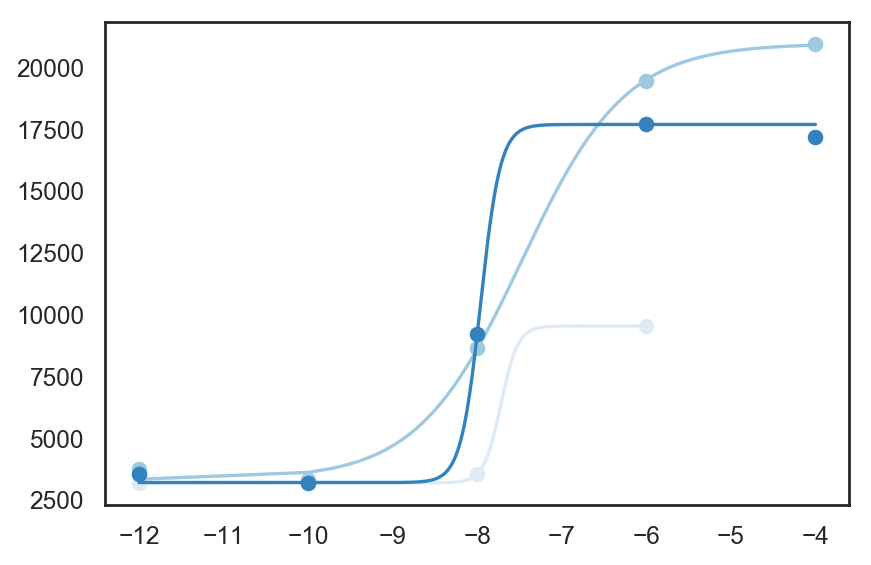

In [41]:
colors = ['#deebf7','#9ecae1','#3182bd']
fig, ax = plt.subplots(figsize=(6, 4))
axs = axes.ravel()
for i,iptg in enumerate(data.IPTG.unique()):
    tmp = data[data.IPTG==iptg]
    def func(x, a, b):
        return (tmp['FITC-A'].max() -tmp['FITC-A'].min()) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + tmp['FITC-A'].min()
    (a_, b_), _ = opt.curve_fit(func, tmp.AHL, tmp['FITC-A'],p0=[1,1e-9],maxfev=10000000)
    n = 1e6
    x = np.linspace(tmp.AHL.min(), tmp.AHL.max(), n)
    print(a_,b_)
    y_fit = func(x, a_, b_)

    
    ax.plot(np.log10(tmp.AHL.values), tmp['FITC-A'].values, 'o',color = colors[i])
    ax.plot(np.log10(x), y_fit, '-',color = colors[i])
plt.show()

In [31]:
tmp.AHL

2     1.000000e-12
5     1.000000e-10
8     1.000000e-08
11    1.000000e-06
13    1.000000e-04
Name: AHL, dtype: float64

In [32]:
#a, c = np.random.exponential(size=2,scale=1e4)
#b, d = np.random.randn(2)
a,b,c,d = 5000,1000,1e2,1e-5
n = 100
#x = np.linspace(-12, -4, n)
x = np.logspace(-12,-4,n)
y_model = f(x, a, b, c, d)
y = y_model + a * .2 * np.random.randn(n)
#(a_, b_, c_, d_), _ = opt.curve_fit(f, x, y,p0=[1e4,1,1,d])
#y_fit = f(x, a_, b_, c_, d_)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y_model, '--k')
ax.plot(x, y, 'o')
#ax.plot(x, y_fit, '-')
plt.xscale('log')



TypeError: 'Figure' object is not callable

In [ ]:
print(a_, b_, c_, d_)

In [ ]:
np.log10(0)

In [ ]:
x

In [ ]:
data


In [ ]:
df.AHL.unique()

In [ ]:
df[df.AHL==1e-4]['FITC-A']

In [ ]:
sns.kdeplot(df[df.AHL==1e-4]['FITC-A'])

In [ ]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
#rs = np.random.RandomState(1979)
#x = rs.randn(500)
#g = np.tile(list("ABCDEFGHIJ"), 50)
#df = pd.DataFrame(dict(x=x, g=g))
#m = df.g.map(ord)
#df["x"] += m
tmpdf = df[df.IPTG==0][['AHL','FITC-A']]
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(tmpdf, row="AHL", hue="AHL", aspect=5, height=0.5, palette=pal)
g.set(xlim=(0, 20000))
# Draw the densities in a few steps
g.map(sns.kdeplot, "FITC-A", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "FITC-A", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "FITC-A")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

